## 1. Data Splitting

This method consists in randomly spliting a given sample in two subsamples: train and test. Usually, as a convention, it is set 75% for train and 25% for test. The training sample is used for estimating the parameters of the underlying model, while the testing sample is used to evalute the predictive capacity of the model with out-of-sample data. 

Let's suppose that we have a training sample, and we estimate the following model:

$$Y^{TR} = \beta_1 X_1^{TR}+\beta_2 X_2^{TR} + \epsilon^{TR}$$

Which will yield estimated values for the coefficients: $\widehat{\beta_1}$, $\widehat{\beta_2}$. Now, to evaluate the ability of this particular model to predict out-of-sample observations, we construct the predicted values of the testing sample:

$$\widehat{Y^{TE}} =\widehat{\beta_1} X_1^{TE}+\widehat{\beta_2} X_2^{TE}$$

Then, we could measure the MSE of these predictions:

$$MSE^{TE} = \frac{1}{N^{TE}}\sum_{i=1}^{N^{TE}} \left(Y^{TE}-\widehat{Y^{TE}}\right)^2$$

And therefore have a more accurate measure of the ability of the model to predict.

## 2. k-fold Cross Validation

It's an algorithm to estimate prediction errors.

Consider a sample that is partitioned in K blocks, or folds (generally, K = 5,10). The idea is to make recursive estimations of a given model, with varying training and testing samples. The k-fold cross validation method relies on the following steps:

Consider a number of values for the tuning parameter $\lambda_j = {\lambda_1,...,\lambda_m}$

Consider a number of folds $k = {1,...,K}$

1. For each $\lambda_j = {\lambda_1,...,\lambda_m}$

   1.1 For each $k = {1,...,K}$:
     
          1.1.1 Estimate the model using every fold BUT i-fold.

          1.1.2 With the coefficients estimated in (1.1.1), make an out-of-sample prediction of i-fold, calculate the estimation error and store it.
    
          1.1.3 Return to (1.1), and iterate over all others k = {1,...,K}.

   1.2 Return to (1) and iterate over all others  $\lambda_j = {\lambda_1,...,\lambda_m}$


This process will yield a set of estimation errors: for every observation inside an i-fold, for every fold, and for every $\lambda_j$. Over a particular $\lambda_j$, consider that the average error of all folds is given by:

$$Average Error (\lambda) = \frac{1}{N}\sum_{k=1}^K \sum_{i \in F_k} \left(y_i-\widehat{y_{\lambda}^{-k}}\right)^2$$

Where $\widehat{y_{\lambda}^{-k}}$ is the prediction of a particular observation in fold "k", made with coefficients from a regression over all other folds.

The optimal $\lambda$, from all posible $\lambda_j = {\lambda_1,...,\lambda_m}$ is be the one that minimizes the Average Error, that is:

$$\hat\lambda = \underset{\lambda \in {\lambda_1,...,\lambda_m}} {argmin} Average Error (\lambda)$$

We used K-cross Validation to estimate an optimal lambda in a context of a Lasso regression

## 3. Replication of PM1_Notebook1_Prediction_newdata

install.packages("caret")
install.packages("ggplot2")
install.packages("tidyverse")
install.packages( "glmnet" )
install.packages( "lmtest" )
install.packages( "sandwich")
install.packages( "coefplot")
install.packages('collapse')
install.packages('doBy')
install.packages("hdm")

In [1]:
library("hdm")
library('doBy')
library('collapse')
library("ggplot2")
library("tidyverse")
library("lubridate")
library("glmnet")
library("lmtest")
library("sandwich")
library("readr")
library("dplyr")
library("caret")
library("repr")

collapse 1.7.6, see ?`collapse-package` or ?`collapse-documentation`


Attaching package: 'collapse'


The following object is masked from 'package:stats':

    D


-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks stats::lag()
x dplyr::order_by() masks doBy::order_by()


Attaching package: 'lubridate'


The following object is masked from 'package:collapse':

    is.Date


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, 

In [2]:
#Charge data, transform to dataframe
load("wage2015_subsample_inference.Rdata")
df <- as.data.frame(data)

[1] "Wages have a long tail at the right(extreme values). Looks like a log-Normal distribution"

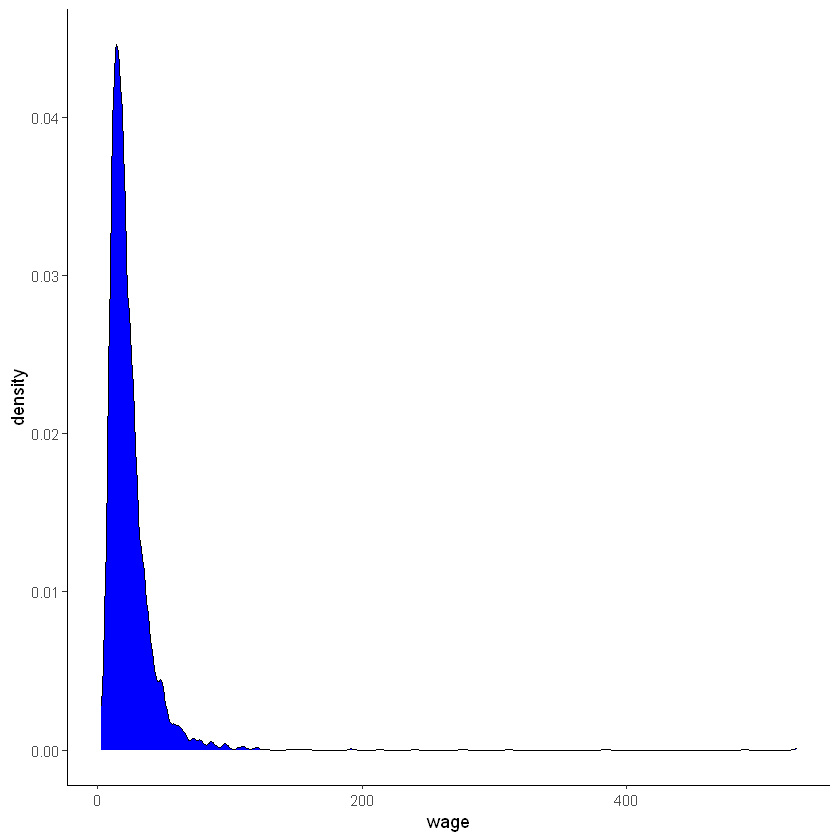

In [3]:
'Wages have a long tail at the right(extreme values). Looks like a log-Normal distribution'
ggplot(data)+geom_density(aes(.data$wage), fill="blue")+theme_classic()


[1] "LogWages have a long tail at the right(extreme values), but it is less notorious."

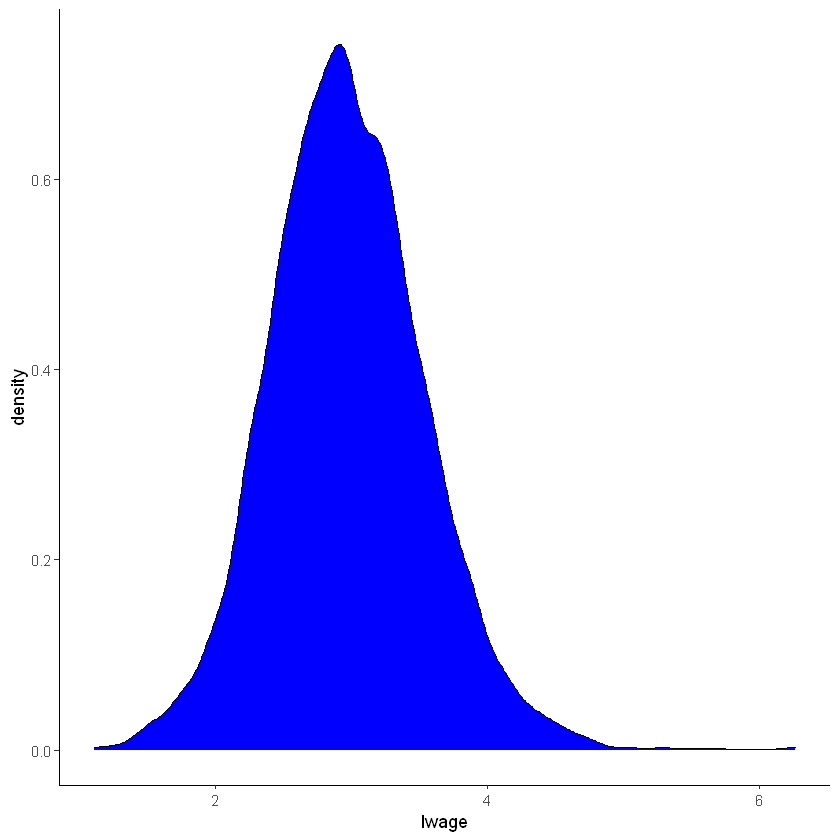

In [4]:
'LogWages have a long tail at the right(extreme values), but it is less notorious.'
ggplot(data)+geom_density(aes(.data$lwage), fill="blue")+theme_classic()


[1] "The Database has mostly men"

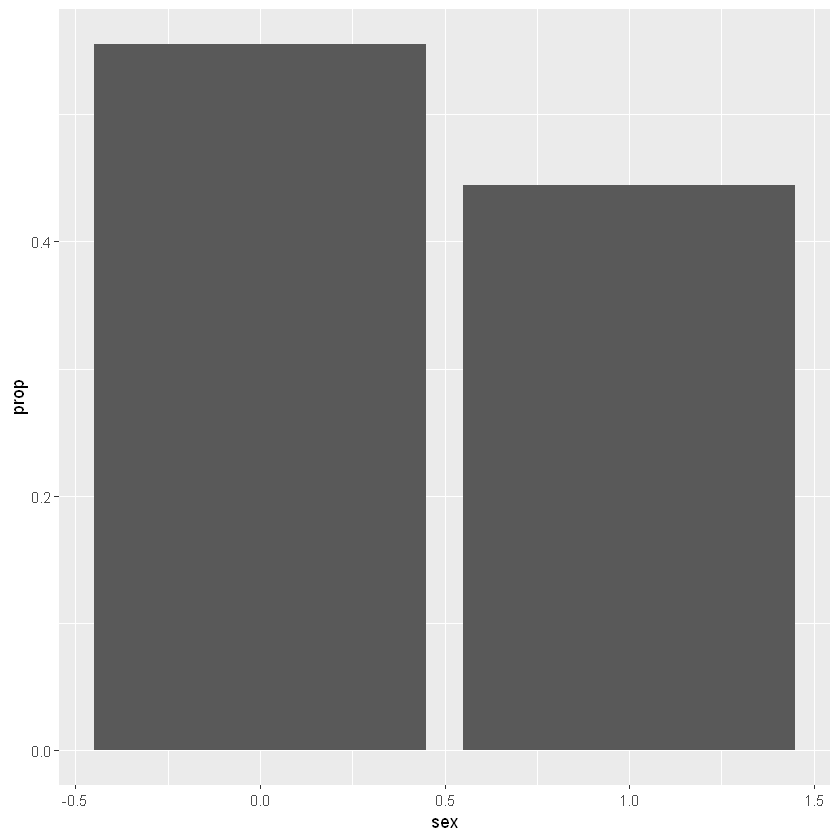

In [5]:
'The Database has mostly men'
ggplot(data,aes(sex))+geom_bar(aes(y=stat(prop),group=1))


[1] "The distribution between SHS (Some High School), HSG(High School Graduate), SCL(Some College),\nCLG(College Graduate) y AD (Advance) is presented in the figure below. The sample is represented mostly by high-school and college graduates"

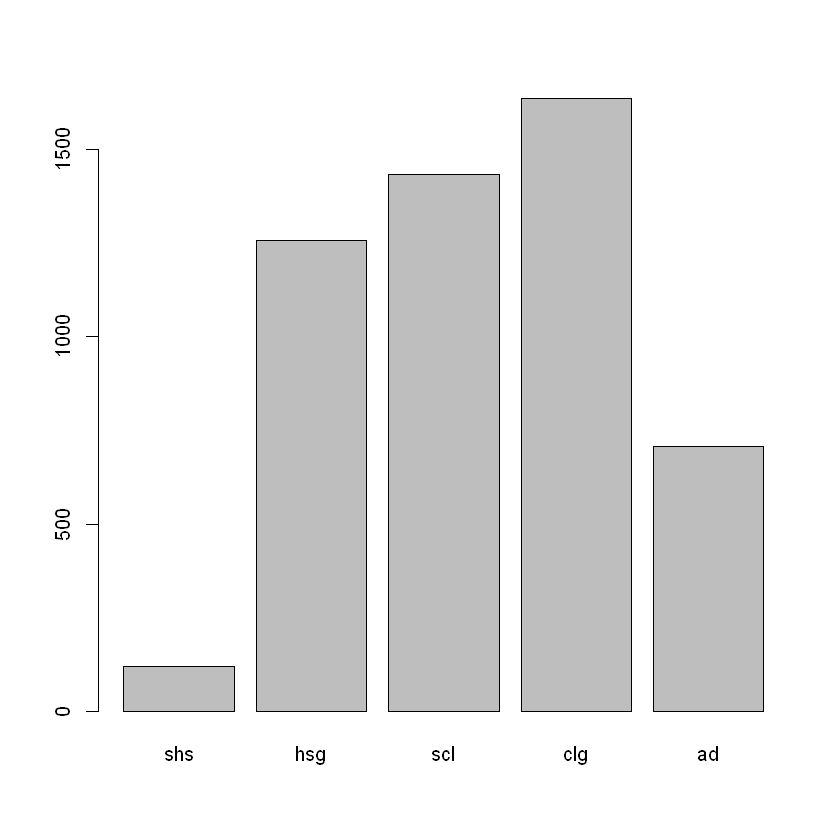

In [6]:
'The distribution between SHS (Some High School), HSG(High School Graduate), SCL(Some College),
CLG(College Graduate) y AD (Advance) is presented in the figure below. The sample is represented mostly by high-school and college graduates'
educationgraph <- data.frame(name=c("shs","hsg","scl","clg","ad"),value=c(sum(data$shs),sum(data$hsg),sum(data$scl),sum(data$clg),sum(data$ad)))
barplot(height=educationgraph$value,names=educationgraph$name)


[1] "The distribution of experience has some sort of left bias"

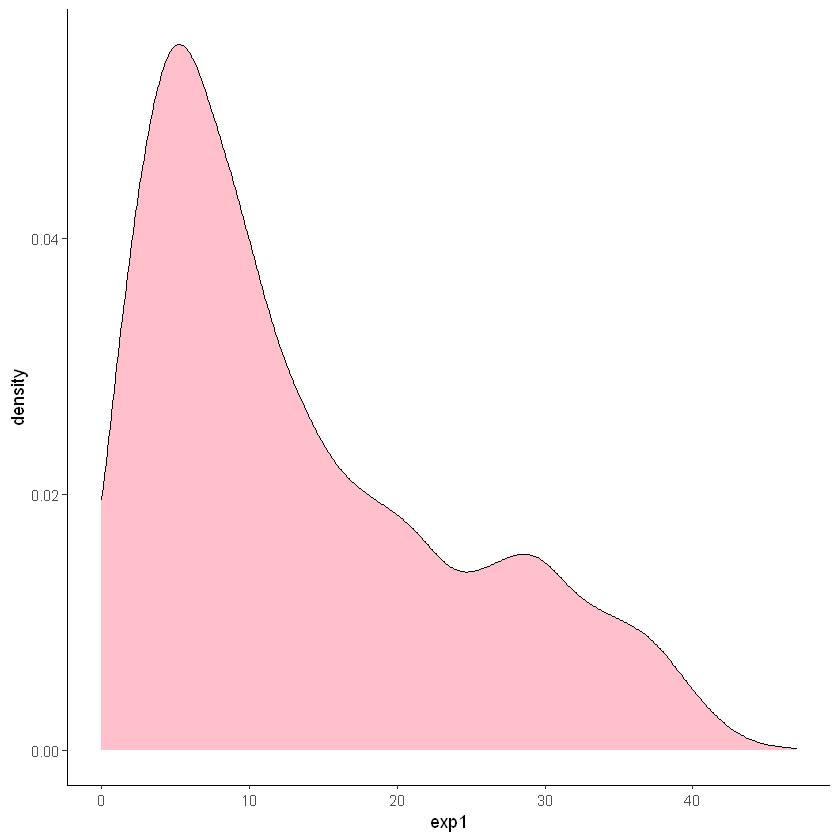

In [7]:
'The distribution of experience has some sort of left bias'
ggplot(data)+geom_density(aes(.data$exp1), fill="pink")+theme_classic()

Now, filtering the dataframe, to consider only observations that **did not** go to college.

In [8]:
#Filtering df
df["intercept"] <- 1
df <- filter(df,(shs==1|hsg==1))
row.names(df) <- NULL

In [9]:
dim(df)

[1] 1376   21

Let's have a look at the data

In [10]:
summary(df)

      wage             lwage            sex              shs         
 Min.   :  3.365   Min.   :1.214   Min.   :0.0000   Min.   :0.00000  
 1st Qu.: 10.989   1st Qu.:2.397   1st Qu.:0.0000   1st Qu.:0.00000  
 Median : 14.615   Median :2.682   Median :0.0000   Median :0.00000  
 Mean   : 17.854   Mean   :2.719   Mean   :0.3219   Mean   :0.08721  
 3rd Qu.: 20.097   3rd Qu.:3.001   3rd Qu.:1.0000   3rd Qu.:0.00000  
 Max.   :528.846   Max.   :6.271   Max.   :1.0000   Max.   :1.00000  
                                                                     
      hsg              scl         clg          ad          mw        
 Min.   :0.0000   Min.   :0   Min.   :0   Min.   :0   Min.   :0.0000  
 1st Qu.:1.0000   1st Qu.:0   1st Qu.:0   1st Qu.:0   1st Qu.:0.0000  
 Median :1.0000   Median :0   Median :0   Median :0   Median :0.0000  
 Mean   :0.9128   Mean   :0   Mean   :0   Mean   :0   Mean   :0.2863  
 3rd Qu.:1.0000   3rd Qu.:0   3rd Qu.:0   3rd Qu.:0   3rd Qu.:1.0000  
 Max.   :1.000

#### Normal, OLS Regressions

In [11]:
#Setting models
basic_model <- "lwage ~ sex + exp1 + shs + hsg+ scl + clg + mw + so + we + occ2+ ind2"
flex_model <- "lwage ~ sex + (exp1+exp2+exp3+exp4+shs+hsg+scl+clg+occ2+ind2+mw+so+we)^2"

#### Basic Model

In [12]:
basic_results <- lm(basic_model,data = df)
est_basic <- basic_results$coef[2]
std_basic <- summary(basic_results)$coef[2,2]
ci_basic <- confint(basic_results)[2,]

In [13]:
print(paste0("The coefficient asocciated with sex is ",est_basic))
print(paste0("and it has a standard deviation of ",std_basic))

[1] "The coefficient asocciated with sex is -0.0733094462839272"
[1] "and it has a standard deviation of 0.0314431124627201"


#### Flexible Model

In [14]:
flex_results <- lm(flex_model,data=df)
est_flex <- flex_results$coef[2]
std_flex <- summary(flex_results)$coef[2,2]
ci_flex <- confint(flex_results)[2,]

In [15]:
print(paste0("The coefficient asocciated with sex is ",est_flex))
print(paste0("and it has a standard deviation of ",std_flex))

[1] "The coefficient asocciated with sex is -0.0883294670230902"
[1] "and it has a standard deviation of 0.0383266150021248"


In [16]:
est_flex
std_flex

sex 
-0.08832947

[1] 0.03832662

[1] "Plotting confidence intervals"

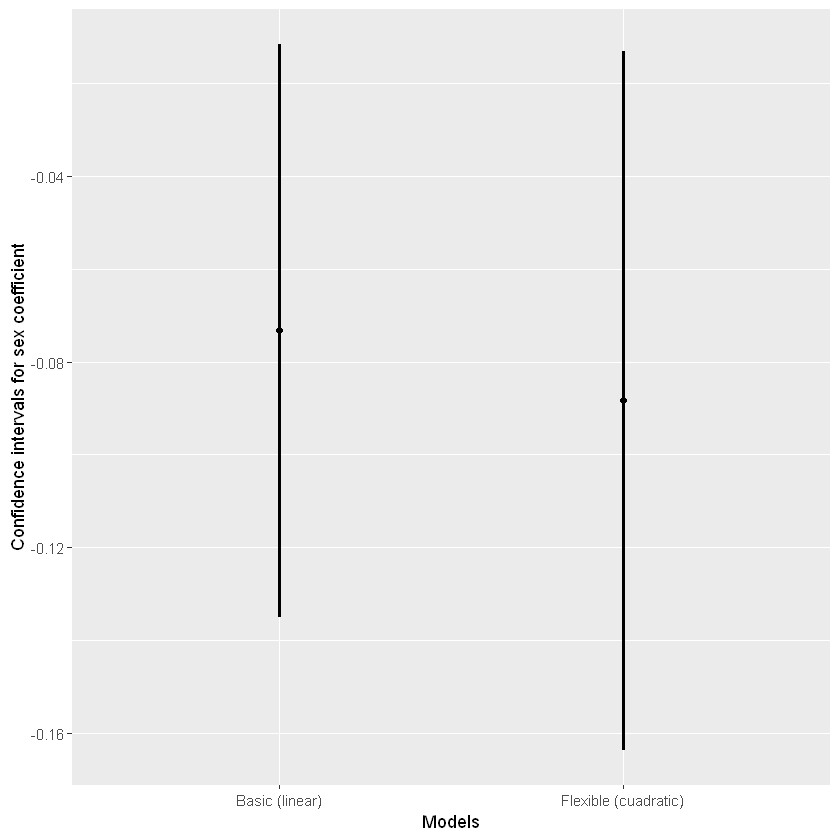

In [17]:
'Plotting confidence intervals'
CIdf <- data.frame(x = c('Basic (linear)','Flexible (cuadratic)'),
                         y = c(est_basic,est_flex),
                         lower = c(ci_basic[1] ,ci_flex[1]),
                         upper = c(ci_basic[2] ,ci_flex[2]))

ggplot(CIdf, aes(x, y)) +        # ggplot2 plot with confidence intervals
  geom_point() +
  geom_errorbar(aes(ymin = lower, ymax = upper),size=1,width=0)+
  xlab("Models")+ ylab("Confidence intervals for sex coefficient")


## 4. Partialling-out via Lasso

We make the Partialling Out procedure to recover the sex coefficient. Specifically, the intermediate-regressions are done with the lasso regression, in order to penalize the large number of independent variables. Hence, some of the estimated coefficients will be set to zero by this method.

The case 1 is a linear specification of the dependent variables, where we only use one variable to measure experience.

The case 2 is a cuadratic specification of the dependent variables, that allows for mixed effects. Hence, we will have more regressors than in case 1, but the Lasso regression will set most of them to zero. We also use the four variables for experience.

The idea behind Lasso Regression is to reduce the variance of some coefficients in a context of a high number of independent variables relative to the sample size. This will allow to make a better inference of them.

### <span style="color:blue">Case 1</span>

In [137]:
r.Y_1 <- rlasso("lwage ~ exp1 + shs + hsg+ scl + clg + mw + so + we + occ2+ ind2",data=df, post=TRUE,intercept = TRUE)$res
r.D_1 <- rlasso("sex ~ exp1 + shs + hsg+ scl + clg + mw + so + we + occ2+ ind2",data=df, post=TRUE,intercept = TRUE)$res
partial.lasso_1 <- lm(r.Y_1 ~ r.D_1-1)
est_lasso_1 <- partial.lasso_1$coef[1]
std_lasso_1 <- summary(partial.lasso_1)$coef[1,2]
ci_lasso_1 <- confint(partial.lasso_1)[1,]

In [143]:
rlasso("sex ~ exp1 + shs + hsg+ scl + clg + mw + so + we + occ2+ ind2",data=df, post=TRUE)$lambda0
rlasso("lwage ~ exp1 + shs + hsg+ scl + clg + mw + so + we + occ2+ ind2",data=df, post=TRUE,intercept = TRUE)$lambda0

[1] 296.3132

[1] 296.3132

### <span style="color:blue">Case 2</span>


In [120]:
r.Y_2 <- rlasso("lwage ~ (exp1+exp2+exp3+exp4+shs+hsg+occ2+ind2+mw+so+we)^2",data=df, post=TRUE,lambda.start=0.00077)$res
r.D_2 <- rlasso("sex ~ (exp1+exp2+exp3+exp4+shs+hsg+occ2+ind2+mw+so+we)^2",data=df, post=TRUE,lambda.start=0.00077)$res
partial.lasso_2 <- lm(r.Y_2 ~ r.D_2-1)
est_lasso_2 <- partial.lasso_2$coef[1]
std_lasso_2 <- summary(partial.lasso_2)$coef[1,2]
ci_lasso_2 <- confint(partial.lasso_2)[1,]

In [ ]:
rlasso("lwage ~ (exp1+exp2+exp3+exp4+shs+hsg+occ2+ind2+mw+so+we)^2",data=df, post=TRUE)$lambda0
rlasso("sex ~ (exp1+exp2+exp3+exp4+shs+hsg+occ2+ind2+mw+so+we)^2",data=df, post=TRUE)$lambda0

This table summarizes the main results for the variable sex.

As we can see, the Double Lasso **does not** help to reduce variance in the linear specification. 

However, the Double Lasso **does help** to reduce variance in the cuadratic specification, leading to a smaller confidence interval, and, although a lower coefficient, to a higher t-statistic.

In [121]:
library(xtable)
table <- matrix(0, 4, 4)
table[1,1:4]   <- c(est_basic,std_basic,ci_basic[1],ci_lasso_1[2])
table[2,1:4]   <- c(est_lasso_1,std_lasso_1,ci_lasso_1[1],ci_lasso_1[2])
table[3,1:4]   <- c(est_flex,std_flex,ci_flex[1],ci_flex[2])
table[4,1:4]   <- c(est_lasso_2,std_lasso_2,ci_lasso_2[1],ci_lasso_2[2])
colnames(table) <-c("Estimator","Standard error", "Lower bound CI", "Upper bound CI")
rownames(table) <-c("Basic OLS","Basic: PO / Double Lasso","Flexible OLS","Flexible: PO / Double Lasso")
tab<- xtable(table, digits = 3)
tab

,Estimator,Standard error,Lower bound CI,Upper bound CI
,<dbl>,<dbl>,<dbl>,<dbl>
Basic OLS,-0.07330945,0.03144311,-0.1349930,-0.02890829
Basic: PO / Double Lasso,-0.09065628,0.03147693,-0.1524043,-0.02890829
Flexible OLS,-0.08832947,0.03832662,-0.1635516,-0.01310734
Flexible: PO / Double Lasso,-0.08141371,0.03167691,-0.1435540,-0.01927342


In all models, the coefficient for the variable sex is negative, reproducing the fact that, in the sample, on average, women earn less than men.

[1] "Plotting confidence intervals"

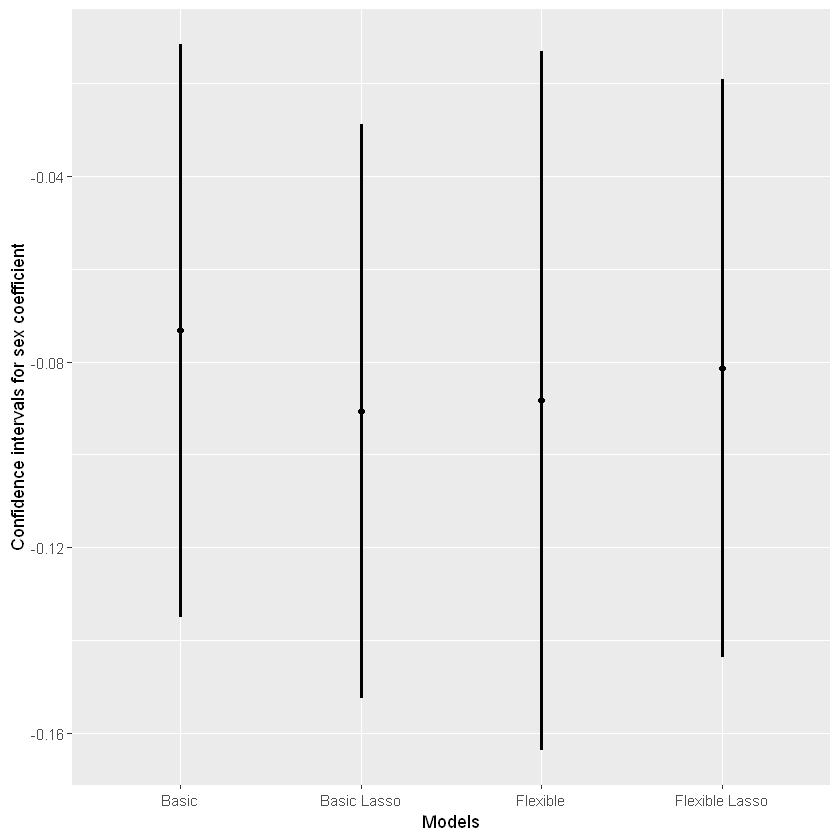

In [154]:
'Plotting confidence intervals'
CIdf <- data.frame(x = c('Basic', 'Basic Lasso','Flexible','Flexible Lasso'),
                         y = c(est_basic,est_lasso_1,est_flex,est_lasso_2),
                         lower = c(ci_basic[1],ci_lasso_1[1],ci_flex[1] ,ci_lasso_2[1]),
                         upper = c(ci_basic[2],ci_lasso_1[2],ci_flex[2] ,ci_lasso_2[2]))

ggplot(CIdf, aes(x, y)) +        # ggplot2 plot with confidence intervals
  geom_point() +
  geom_errorbar(aes(ymin = lower, ymax = upper),size=1,width=0)+
  xlab("Models")+ ylab("Confidence intervals for sex coefficient")
